In [1]:
import cv2
import torch
import random
import numpy as np
from PIL import Image
from torch import optim
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from dataset import Conv_Att_MCI_Dataset
from models import BaseModel, VGG16GradCAM

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
batch_size = 64
n_epochs = 100

#optimizer
lr = 1e-5
beta_1 = 0.9
beta_2 = 0.99
eps = 1e-7

## Early stopping
es_size = 4

In [4]:
dataset = Conv_Att_MCI_Dataset('clock')
dataset_trn, dataset_val, dataset_test = dataset.split_trn_val_test()
dataloader_trn = DataLoader(dataset_trn, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [5]:
# model = BaseModel().to(device)
model = VGG16GradCAM().to(device)

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
optimizer = optim.Adam(model.parameters(), lr, [beta_1, beta_2], eps)

In [7]:
results = {
    'losses':{'trn':[], 'val':[], 'test':[]},
    'corrects':{'trn':[], 'val':[], 'test':[]},
    'accs':{'trn':[], 'val':[], 'test':[]},
}
es_queue, es_flag = deque(maxlen=es_size), False
for epoch in range(n_epochs):
    _losses, _corrects, n_tot = [],[],0
    for x, y, info in dataloader_trn:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

        _losses.append(loss.item())
        _corrects.append(_correct)
        n_tot += len(x)
    
    accs = sum(_corrects) / n_tot
    results['losses']['trn'].append(np.mean(_losses))
    results['corrects']['trn'].append(sum(_corrects))
    results['accs']['trn'].append(accs)

    _losses, _corrects, n_tot = [],[],0
    for x, y, info in dataloader_val:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, y)

        _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

        _losses.append(loss.item())
        _corrects.append(_correct)
        n_tot += len(x)
    
    accs = sum(_corrects) / n_tot
    results['losses']['val'].append(np.mean(_losses))
    results['corrects']['val'].append(sum(_corrects))
    results['accs']['val'].append(accs)

    _losses, _corrects, n_tot = [],[],0
    for x, y, info in dataloader_test:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, y)

        _correct = ((y_prob.cpu() >= 0.5) == info['labels']).sum()

        _losses.append(loss.item())
        _corrects.append(_correct)
        n_tot += len(x)
    
    accs = sum(_corrects) / n_tot
    results['losses']['test'].append(np.mean(_losses))
    results['corrects']['test'].append(sum(_corrects))
    results['accs']['test'].append(accs)  

    es_queue.append(results['losses']['val'][-1])
    if len(es_queue) >= es_size:
        if (np.diff(es_queue) > 0).all():
            es_flag = True

    print("| Epoch %d/%d |"%(epoch+1, n_epochs), end=' Early stopping!\n' if es_flag else '\n')
    print("| Train      | Loss %6.2f | Acc. %6.2f |"%(results['losses']['trn'][-1], results['accs']['trn'][-1]))
    print("| Validation | Loss %6.2f | Acc. %6.2f |"%(results['losses']['val'][-1], results['accs']['val'][-1]))
    print("| Test       | Loss %6.2f | Acc. %6.2f |"%(results['losses']['test'][-1], results['accs']['test'][-1]))

    if es_flag:
        break


| Epoch 1/100 |
| Train      | Loss   0.64 | Acc.   0.67 |
| Validation | Loss   0.61 | Acc.   0.71 |
| Test       | Loss   0.67 | Acc.   0.71 |
| Epoch 2/100 |
| Train      | Loss   0.61 | Acc.   0.71 |
| Validation | Loss   0.61 | Acc.   0.71 |
| Test       | Loss   0.67 | Acc.   0.71 |
| Epoch 3/100 |
| Train      | Loss   0.59 | Acc.   0.72 |
| Validation | Loss   0.62 | Acc.   0.71 |
| Test       | Loss   0.65 | Acc.   0.73 |
| Epoch 4/100 |
| Train      | Loss   0.58 | Acc.   0.75 |
| Validation | Loss   0.60 | Acc.   0.69 |
| Test       | Loss   0.63 | Acc.   0.77 |
| Epoch 5/100 |
| Train      | Loss   0.56 | Acc.   0.77 |
| Validation | Loss   0.61 | Acc.   0.70 |
| Test       | Loss   0.63 | Acc.   0.78 |
| Epoch 6/100 |
| Train      | Loss   0.53 | Acc.   0.78 |
| Validation | Loss   0.60 | Acc.   0.71 |
| Test       | Loss   0.63 | Acc.   0.73 |
| Epoch 7/100 |
| Train      | Loss   0.52 | Acc.   0.80 |
| Validation | Loss   0.59 | Acc.   0.69 |
| Test       | Loss   0.61 |

KeyboardInterrupt: 

torch.Size([1, 3, 256, 256]) tensor([0.9707]) tensor([1.])
torch.Size([1, 8, 8])
(256, 256, 3)


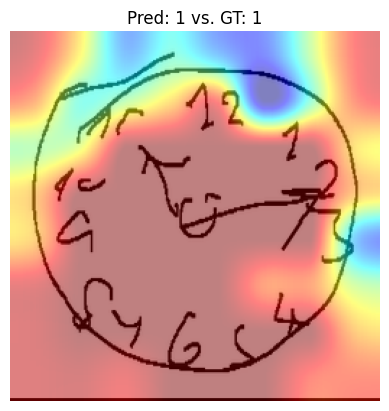

In [32]:
idx = 257
img = dataset_test.dataset['images'][idx:idx+1].to(device)
score = dataset_test.dataset['scores'][idx:idx+1]
label = dataset_test.dataset['labels'][idx:idx+1]
print(img.shape, score, label)

y_pred = model(img)
class_idx = y_pred.argmax(-1).item()
heatmap = model.generate_cam(img, class_idx).cpu()
print(heatmap.shape)

heatmap = np.uint8(255 * heatmap)
heatmap = np.uint8(Image.fromarray(heatmap[0]).resize((img.shape[2], img.shape[3])))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print(heatmap.shape)

alpha = 1.0
superimposed_img = heatmap * alpha #+ img[0].permute(1,2,0).detach().cpu().numpy()
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

plt.imshow(img[0].detach().cpu().permute(1,2,0))
plt.imshow(heatmap, alpha=0.5)
plt.axis('off')
plt.title('Pred: %d vs. GT: %d'%(y_pred.argmax(-1).item(), label.item()))
plt.show()